This notebook implements the approaches of particle filters for SDE representations of SIR models, based on the works of Dargatz and Wieland.

In [1]:
# packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle


In [2]:
# base parameter values

n = 100                         # total population size
s0 = 0.96                       # initial susceptible percentage
i0 = 0.04                       # initial infectious percentage
x0 = np.array([s0,i0])          # initial values
n_dim = x0.shape[0]             # dimension of the process
beta = 0.2                      # infection rate
gamma_inv = 20                  # mean recovery time
zeta = 0.05                     # measurement error
t0 = 0                          # initial time
T = 100                         # final time
t_meas = np.linspace(t0,T,11)  # measurement time points
dt = 0.01                       # step size for positive Euler scheme
ind_meas = [0, 999, 1999, 2999, 3999, 4999, 5999, 6999, 7999, 8999, 9999] # time steps of the observations
N_obs = len(ind_meas)           # number of observations 
N = int((T-t0)/dt)              # number of simulated samples

# SIR approach (synthetic data)

## Create synthetic data

Create synthetic data that will be used for the remaining time untill Vincent gives me his original dataset

In [3]:
# set seed
RNG = np.random.default_rng(seed=24)

In [4]:
# positive Euler-Maruyama method
def pEM(t0, T, dt, x0, mu, sigma):          # postitive Euler-Maruyama for SDE defined through mu and sigma

    # initialise
    i = 0
    t_grid = np.linspace(t0, T, N)
    Y = np.zeros((N,n_dim))
    Y[0] = x0
    mean = np.array([0,0])
    cov = dt*np.eye(n_dim)
    
    #update
    for i in range(N-1):    
        B = RNG.multivariate_normal(mean = mean, cov = cov)
        Y[i+1,0] = np.clip((Y[i] + mu(Y[i],beta, gamma_inv)*dt + np.matmul(sigma(Y[i],beta,gamma_inv, n),B))[0],a_min = 0, a_max = 1)  # first coordinate
        Y[i+1,1] = np.clip((Y[i] + mu(Y[i],beta, gamma_inv)*dt + np.matmul(sigma(Y[i],beta,gamma_inv, n),B))[1],a_min = 0, a_max = 1)  # second coordinate
        i = i + 1

    return t_grid, Y


In [5]:
# define auxiliary functions

def mu_SIR(X, beta, gamma_inv):
    gamma = 1 / gamma_inv


    # version for the simulated data
    out = np.empty_like(X)
    out[0] = -beta*X[0]*X[1]
    out[1] = beta*X[0]*X[1]-gamma*X[1]

    return out

def sigma_SIR(X,beta, gamma_inv,n):
    gamma = 1/gamma_inv

    out = np.eye(X.shape[0])
    out[0,0] = np.sqrt(beta*X[0]*X[1]/n)
    out[1,0] = -np.sqrt(beta*X[0]*X[1]/n)
    out[1,1] = np.sqrt(gamma*X[1]/n)

    return out

In [6]:
def Mu_SIR(X, beta, gamma_inv):
    gamma = 1 / gamma_inv

    
    infection_rate = beta * X[:, 0] * X[:, 1]
    recovery_rate = gamma * X[:, 1]
    out = np.column_stack((-infection_rate, infection_rate - recovery_rate))


    return out



# covarariance matrix turns non-pos def if off-diag entries are too close to zero (on the magnitude of e12)

def Sigma_SIR(X, beta, gamma_inv,n):

    alpha_low = -0.00001    # clipping parameter preventing the entries to get to close to zero
    alpha_up = 0.00002      # in pathological cases, the matrix could loose pos. def. if all values are clipped

    values = np.empty_like(X)
    Sigma = np.ones((values.shape[0],values.shape[1],values.shape[1]))
    for i in range(values.shape[0]):
        proto = dt/n*np.array([[np.clip(beta*X[i][0]*X[i][1], a_min=alpha_up, a_max = None),np.clip(-beta*X[i][0]*X[i][1], a_min = None, a_max=alpha_low)],
                             [np.clip(-beta*X[i][0]*X[i][1], a_min = None, a_max=alpha_low),np.clip(beta*X[i][0]*X[i][1] + X[i][1]/gamma_inv, a_min = alpha_up, a_max = None)]])
        Sigma[i,:,:] = proto
        
    return Sigma

Obtain the data and reproduce the testing scheme

In [7]:
t_grid, simulation = pEM(t0, T, dt, x0, mu_SIR, sigma_SIR)
sim_data = pd.DataFrame({"t": t_grid,"s(t)":simulation[:,0],"i(t)":simulation[:,1]})

Plots, cf. Figure 5.1a

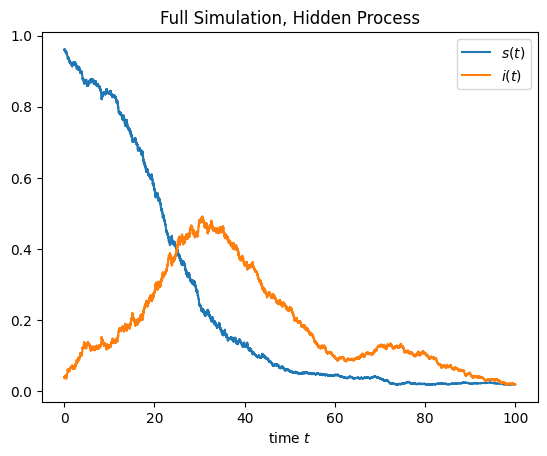

In [8]:
sns.lineplot(sim_data, x = "t", y = "s(t)", label = "$s(t)$")
sns.lineplot(sim_data, x = "t", y = "i(t)", label = "$i(t)$")
plt.ylabel("")
plt.xlabel("time $t$")
plt.title("Full Simulation, Hidden Process")
plt.legend()
plt.savefig("Figure_5.1a.png")
plt.show()


Observations

In [9]:
def observer(sim_data,zeta): # need to simulate the whole observable process

    # initialise
    out = np.zeros((N,len(sim_data.columns)-1))

    for i in range(N):
        out[i,0] = np.clip(sim_data["i(t)"][i] + RNG.normal(scale = zeta),a_min = 0, a_max = 1)      
        out[i,1] = np.clip(1-sim_data["s(t)"][i] + RNG.normal(scale = zeta),a_min = 0, a_max = 1)   
    
    return out

In [10]:
observation = observer(sim_data, zeta)
obs_data = pd.DataFrame({"t":t_grid, "prevalence": observation[:,0], "antibody": observation[:,1]})

hidden_data = pd.DataFrame({"t":t_grid, "susceptible": sim_data["s(t)"], "infected": sim_data["i(t)"]})

Extract hidden and observed values in correct format

In [11]:
# synthetic hidden and observed process

x_syn = []
y_syn = []

for i in range(N):
    x_syn.append(np.array([sim_data["s(t)"][i],sim_data["i(t)"][i]]))
    y_syn.append(np.array([observation[i]]))   
    

5.1b and 5.1c, Observed Processes

In [12]:
# only select measurement times
probe = np.repeat(False, N)
probe[0] = True
probe[999] = True
probe[1999] = True
probe[2999] = True
probe[3999] = True
probe[4999] = True
probe[5999] = True
probe[6999] = True
probe[7999] = True
probe[8999] = True
probe[9999] = True

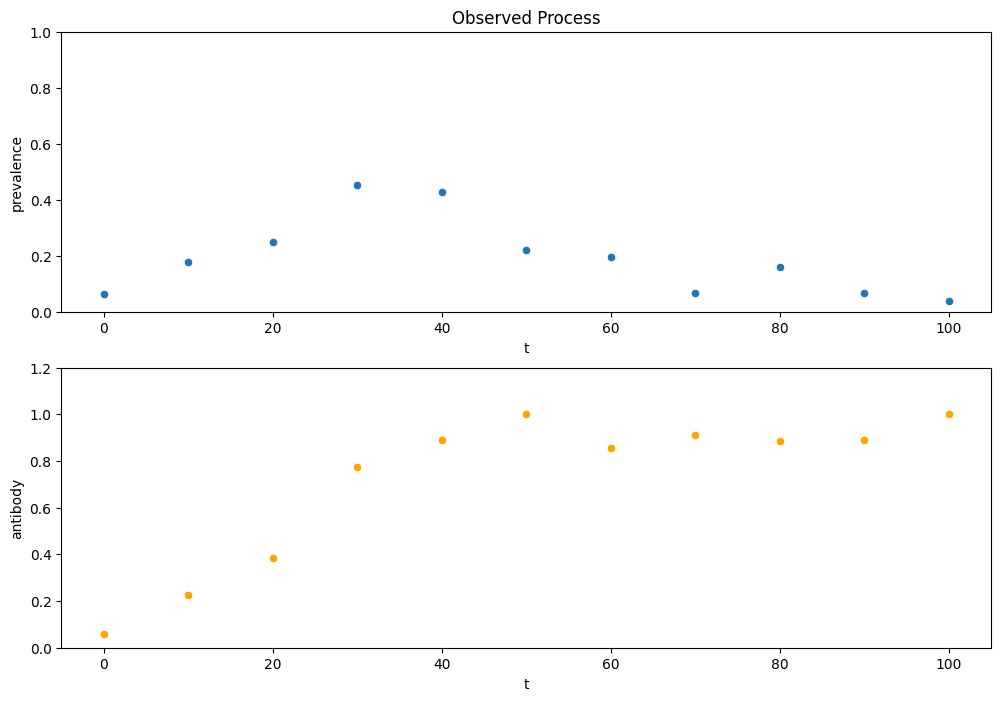

In [13]:
f, axs = plt.subplots(2,1, figsize = (12,8))

sns.scatterplot(obs_data[probe], x = "t", y = "prevalence", ax = axs[0])
axs[0].set_ylim([0,1])
axs[0].set_title("Observed Process")

sns.scatterplot(obs_data[probe], x = "t", y = "antibody", ax = axs[1], color = "orange")
axs[1].set_ylim([0,1.2])

plt.savefig("Figure_5.1bc.png")
plt.show()

Plot the whole simulation along the hidden process as the observation times

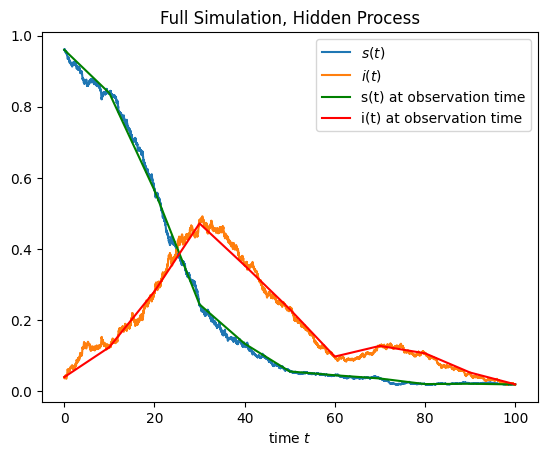

In [14]:
sns.lineplot(sim_data, x = "t", y = "s(t)", label = "$s(t)$")
sns.lineplot(sim_data, x = "t", y = "i(t)", label = "$i(t)$")
sns.lineplot(hidden_data[probe], x = "t", y = "susceptible", color = "green", label = "s(t) at observation time")
sns.lineplot(hidden_data[probe], x = "t", y = "infected", color = "red", label = "i(t) at observation time")
plt.ylabel("")
plt.xlabel("time $t$")
plt.title("Full Simulation, Hidden Process")
plt.legend()
plt.show()


## Particle Filter

We need to truncate the output the normal distribution to ensure the sample lie inside the region $[0,1]$. We do this in a straighforward way by setting all random samples outside of this interval to the boundaries.  However, for a proper distribution, one would also have to modify logpdf and ppf. We don´t do this because truncated multivariate distributions are difficult to model and not a focus of this thesis.

For the implementation, we manually define the classes "TruncVaryingCovNorm" of with random samples are manually clipped to $[0,1]$ and where the covariance may be different for each particle as well. 

In [15]:
# modules

import particles

from particles import state_space_models as ssm
from particles import distributions as dists

import numpy.linalg as nla
import scipy.linalg as sla
from scipy import stats

HALFLOG2PI = 0.5 * np.log(2.0 * np.pi)

In [16]:
class TruncMvNormal(dists.ProbDist):
    """Truncated Multivariate Normal distribution.

    Parameters
    ----------
    loc: ndarray
        location parameter (default: 0.)
    scale: ndarray
        scale parameter (default: 1.)
    cov: (d, d) ndarray
        covariance matrix (default: identity, with dim determined by loc)

    Notes
    -----
    The dimension d is determined either by argument ``cov`` (if it is a dxd
    array), or by argument loc (if ``cov`` is not specified). In the latter
    case, the covariance matrix is set to the identity matrix.

    If ``scale`` is set to ``1.`` (default value), we use the standard
    parametrisation of a Gaussian, with mean ``loc`` and covariance
    matrix ``cov``. Otherwise::

        x = dists.MvNormal(loc=m, scale=s, cov=Sigma).rvs(size=30)

    is equivalent to::

        x = m + s * dists.MvNormal(cov=Sigma).rvs(size=30)

    The idea is that they are cases when we may want to pass varying
    means and scales (but a fixed correlation matrix). Note that
    ``cov`` does not need to be a correlation matrix; e.g.::

        MvNormal(loc=m, scale=s, cov=C)

    corresponds to N(m, diag(s)*C*diag(s)).

    In addition, note that m and s may be (N, d) vectors;
    i.e for each n=1...N we have a different mean, and a different scale.

    To specify a Multivariate Normal distribution with a different covariance
    matrix for each particle, see `VaryingCovNormal`.
    """

    def __init__(self, loc=0.0, scale=1.0, cov=None):
        self.loc = loc
        self.scale = scale
        self.cov = np.eye(loc.shape[-1]) if cov is None else cov
        err_msg = "MvNormal: argument cov must be a (d, d) pos. definite matrix"
        try:
            self.L = nla.cholesky(self.cov)  # lower triangle
        except nla.LinAlgError:
            raise ValueError(err_msg)
        assert self.cov.shape == (self.dim, self.dim), err_msg

    @property
    def dim(self):
        return self.cov.shape[-1]

    def linear_transform(self, z):
        return self.loc + self.scale * np.dot(z, self.L.T)

    def logpdf(self, x):
        halflogdetcor = np.sum(np.log(np.diag(self.L)))
        xc = (x - self.loc) / self.scale
        z = sla.solve_triangular(self.L, np.transpose(xc), lower=True)
        # z is dxN, not Nxd
        if np.asarray(self.scale).ndim == 0:
            logdet = self.dim * np.log(self.scale)
        else:
            logdet = np.sum(np.log(self.scale), axis=-1)
        logdet += halflogdetcor
        return -0.5 * np.sum(z * z, axis=0) - logdet - self.dim * HALFLOG2PI

    def rvs(self, size=None):
        if size is None:
            sh = np.broadcast(self.loc, self.scale).shape
            # sh=() when both loc and scale are scalars
            N = 1 if len(sh) == 0 else sh[0]
        else:
            N = size
        z = stats.norm.rvs(size=(N, self.dim))
        # return self.linear_transform(z)
        return np.clip(self.linear_transform(z),0.00001,1)    # truncate here, this is rather brutal

    def ppf(self, u):
        """
        Note: if dim(u) < self.dim, the remaining columns are filled with 0.
        Useful when the distribution is partly degenerate.
        """
        N, du = u.shape
        if du < self.dim:
            z = np.zeros((N, self.dim))
            z[:, :du] = stats.norm.ppf(u)
        else:
            z = stats.norm.ppf(u)
        return self.linear_transform(z)

    def posterior(self, x, Sigma=None):
        """Posterior for model: X1, ..., Xn ~ N(theta, Sigma), theta ~ self.

        Parameters
        ----------
        x: (n, d) ndarray
            data
        Sigma: (d, d) ndarray
            covariance matrix in the modelp (default: identity matrix)

        Notes
        -----
        Scale must be set to 1.
        """
        if self.scale != 1.0:
            raise ValueError("posterior of MvNormal: scale must be one.")
        n = x.shape[0]
        Sigma = np.eye(self.dim) if Sigma is None else Sigma
        Siginv = sla.inv(Sigma)
        covinv = sla.inv(self.cov)
        Qpost = covinv + n * Siginv
        Sigpost = sla.inv(Qpost)
        m = np.full(self.dim, self.loc) if np.isscalar(self.loc) else self.loc
        mupost = Sigpost @ (m @ covinv + Siginv @ np.sum(x, axis=0))
        # m @ covinv works whether the shape of m is (N, d) or (d)
        return TruncMvNormal(loc=mupost, cov=Sigpost)

In [17]:
class TruncVaryingCovNormal(dists.MvNormal):
    """Multivariate Normal (varying covariance matrix).

    Parameters
    ----------
    loc: ndarray
        location parameter (default: 0.)
    cov: (N, d, d) ndarray
        covariance matrix (no default)

    Notes
    -----

    Uses this distribution if you need to specify a Multivariate distribution
    where the covariance matrix varies across the N particles. Otherwise, see
    `MvNormal`.
    """

    def __init__(self, loc=0.0, cov=None):
        self.loc = loc
        self.cov = cov
        err_msg = "VaryingCovNormal: argument cov must be a (N, d, d) array, \
                with d>1; cov[n, :, :] must be symmetric and positive"
        try:
            self.N, d1, d2 = self.cov.shape  # must be 3D
            self.L = nla.cholesky(self.cov)  # lower triangle
        except nla.LinAlgError:
            raise ValueError(err_msg)
        assert d1 == d2, err_msg

    def linear_transform(self, z):
        return self.loc + np.einsum("...ij,...j", self.L, z)

    def rvs(self, size=None):
        N = self.N if size is None else size
        z = stats.norm.rvs(size=(N, self.dim))
        # return self.linear_transform(z)
        return np.clip(self.linear_transform(z),0.00001,1) # truncate here, this is rather brutal

    def logpdf(self, x):
        halflogdetcov = np.sum(np.log(np.diagonal(self.L, axis1=1, axis2=2)), axis=1)
        # not as efficient as triangular_solve, but numpy does not have
        # a "tensor" version of triangular_solve
        z = nla.solve(self.L, x - self.loc)
        norm_cst = self.dim * HALFLOG2PI + halflogdetcov
        return -0.5 * np.sum(z * z, axis=1) - norm_cst

    def posterior(self, x, Sigma=None):
        raise NotImplementedError

In [18]:
class SIR(ssm.StateSpaceModel): # base class

    default_params = {"n": n, "s0": s0, "i0": i0, "beta": beta, "gamma_inv": gamma_inv, "zeta": zeta, "t0": t0, "T": T, "t_meas": t_meas}

    # the model already incorporates the information which time points we observe, thus the data must be presented complete
    def PY(self, t, xp, x):
        # select observation times for usable output
        if t in [0, 999, 1999, 2999, 3999, 4999, 5999, 6999, 7999, 8999, 9999]:
            mu = np.column_stack((x[:,1], 1-x[:,0]))
            return TruncMvNormal(loc = mu, scale = self.zeta)

        # ignore all other times
        else:
            return dists.FlatNormal(loc=x)

    def PX(self,t, xp):

        mu = xp + Mu_SIR(xp, self.beta, self.gamma_inv)*dt

        # new covariances that are particle specific
        Sigma = Sigma_SIR(xp, self.beta, self.gamma_inv, self.n)
        # print(Sigma)
        return TruncVaryingCovNormal(loc = mu, cov = Sigma)

    def PX0(self):
        return dists.IndepProd(dists.Dirac(loc = self.s0), 
                               dists.Dirac(loc = self.i0))

#### 5.2 Filter Variation

For this analytic we require several runs for each individual particle number to evaluate their robustness. This is implemented as simple for loops 

In [19]:
"""Figure 5.2"""

# logLts = {}                             # storage variable
# n_runs = 100                            # high number of runs for more stable means and variances
# cand = [10,20,30,40,50,60,70,80,90,100] # candidate particle counts

# for i in range(10):

#     proto = np.repeat(0.0,n_runs)       # dummy variable
#     for j in range(n_runs):
        
#         # algorithm
#         fk_model = ssm.Bootstrap(ssm=SIR(), data=y_syn)
#         alg = particles.SMC(fk=fk_model, N=cand[i], store_history=True)
#         alg.run()   
#         proto[j] = alg.summaries.logLts[-1] # we want the log-likelihood of the whole trajectory

#     logLts[rf"{cand[i]}"] = proto

# # save as file
# with open(rf"logLts.pkl", "wb") as handle:
#     pickle.dump(logLts, handle)

'Figure 5.2'

In [20]:
# load data
with open("logLts.pkl", 'rb') as f:
        logLts = pickle.load(f)

The varinces for the respective particle numbers

In [39]:
variances = np.zeros(10)
for i in [10,20,30,40,50,60,70,80,90,100]:
    print(np.var(logLts[rf"{i}"]))

2.298217835786966
0.8170259435568659
0.6140031449309405
0.49087354838189734
0.32374235633020554
0.2591851096474634
0.22233876430962027
0.25771503765955134
0.15101815462123555
0.18794772369621204


The log-likelihood for the respective particle counts as a violin plot

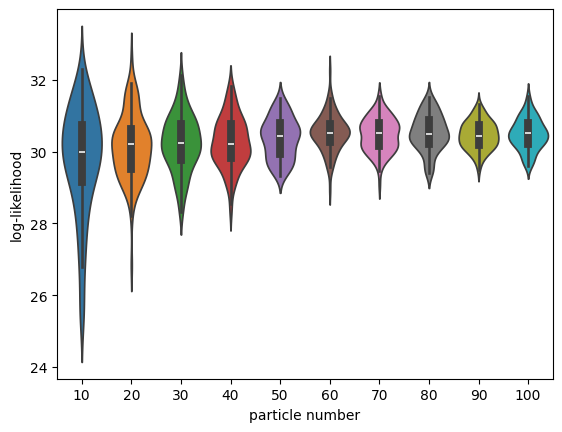

In [38]:
# get violin plot
sns.violinplot(logLts, orient = "v")
plt.xlabel("particle number")
plt.ylabel("log-likelihood")
plt.savefig("Figure_5.2.png")
plt.show()

#### 5.3 Genealogical trees

Analysing the genealogy, we can rely on the built-in method "compute_trajectories".

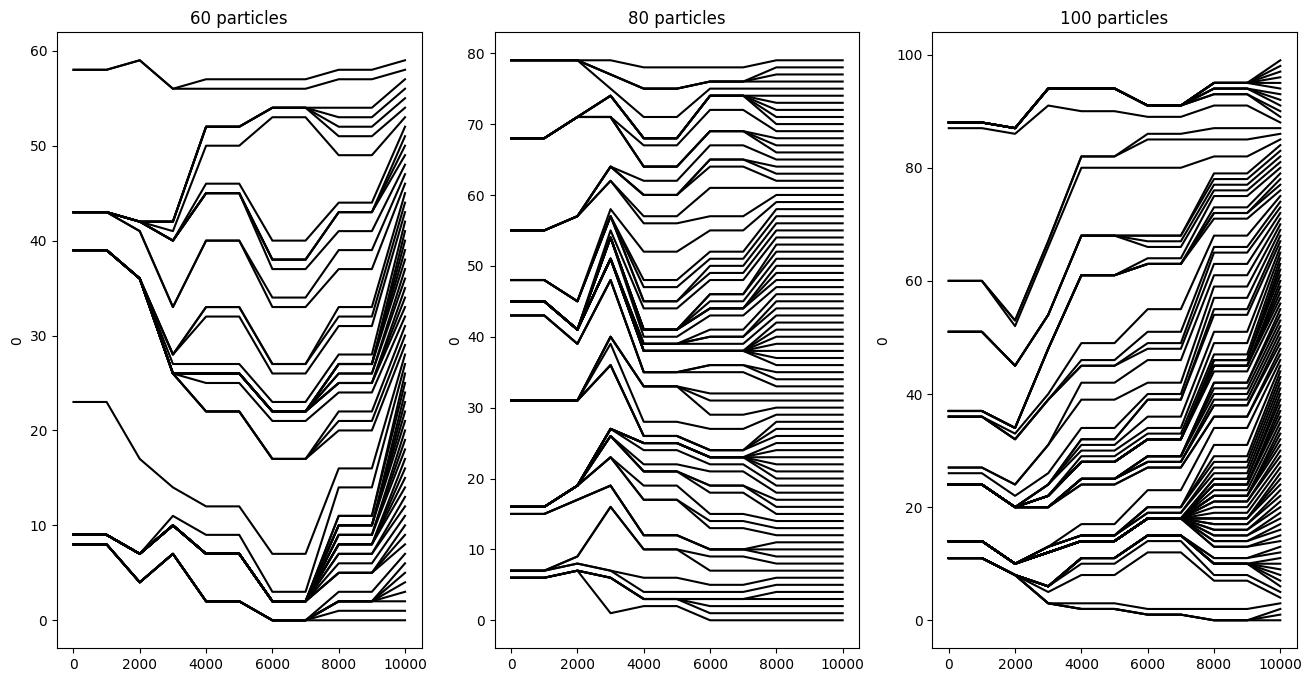

In [43]:
""""Figure 5.3"""
cand = [60, 80, 100]    # candidate particle numbers

fig, axs = plt.subplots(1,3, figsize = (16,8))

for i in range(len(cand)):

    # algorithm
    fk_model = ssm.Bootstrap(ssm=SIR(), data=y_syn)
    alg = particles.SMC(fk=fk_model, N=cand[i], store_history=True)
    alg.run()
    
    # set in method to get the trajectories
    B = alg.hist.compute_trajectories()
    B_data = pd.DataFrame(B)

    # plot
    for j in range(cand[i]):
        sns.lineplot(B_data[probe][j], ax=axs[i], color = "black")
        axs[i].set_title(rf"{cand[i]} particles")

plt.savefig("Figure_5.3.png")

#### 5.4 Confidence Regions

For the confidence regions, we want to incorporate many trajectories with the respective particle numbers and see if they (or their mean and variacence) covers the underlying hidden process that is basis for the observed data the SMC is fed. For this, we flatten all runs such that the means, medians and variances are computed direclty from all available trajectories.

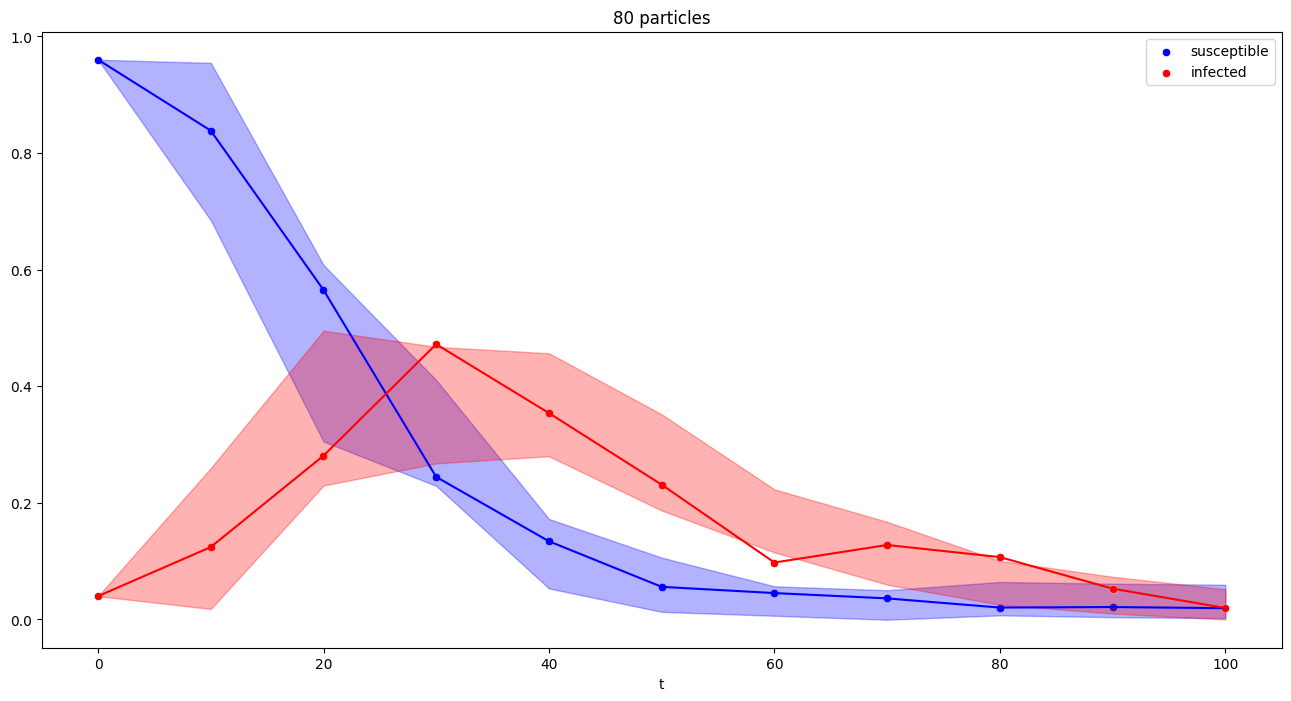

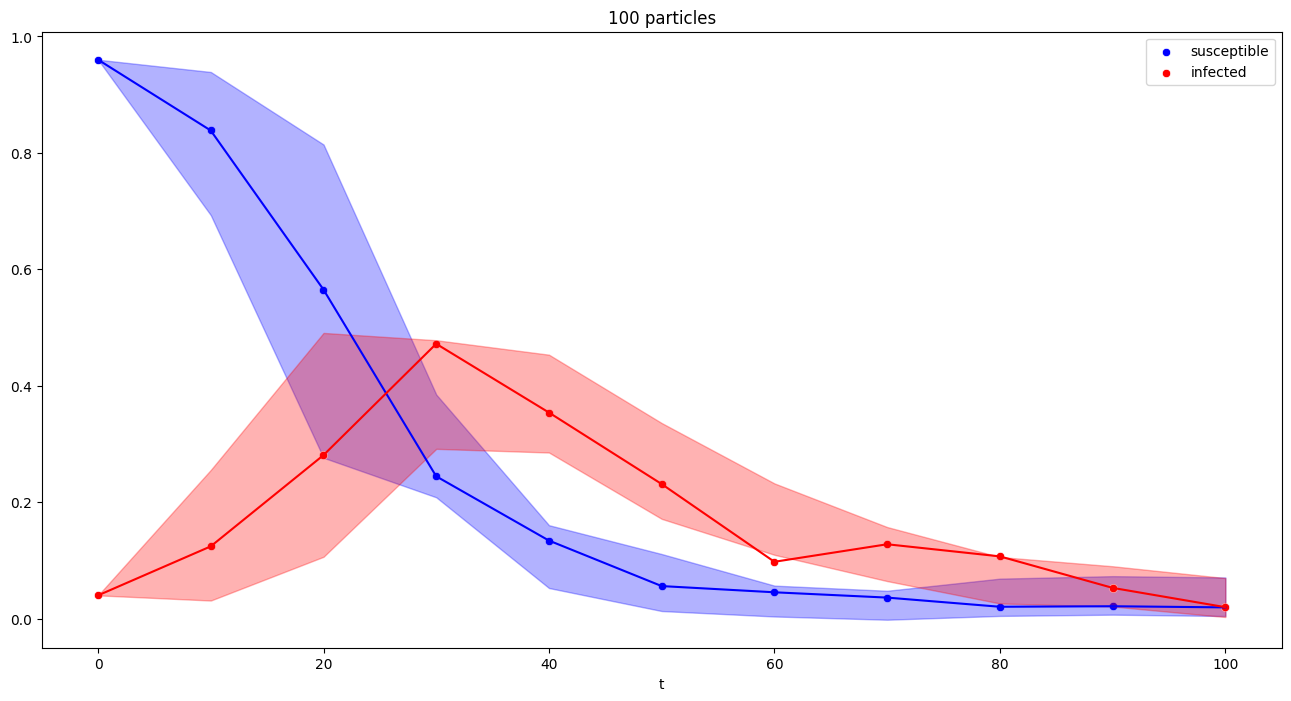

In [ ]:
"""Figure 5.4"""

# cand = [80,100] # candiate particle numbers
# # n_runs = 200    # number of runs
# n_runs = 1
# capt = hidden_data[probe].keys()[1:]    # keys 

# # run over all potential particle numbers
# for i in range(len(cand)):

#     # dummy variable for storage
#     proto = np.zeros((2,n_runs, N_obs,cand[i]))                             # 1st or 2nd component, number run, time measurement, trajectory 
#     # repeat over several runs for more stable means and variances
#     for j in range(n_runs):
        
#         # the algorithm
#         fk_model = ssm.Bootstrap(ssm=SIR(), data=y_syn)                     
#         alg = particles.SMC(fk=fk_model, N=cand[i], store_history=True) 
#         alg.run()
#         # save all trajectories
#         for k in range(N_obs):
#             proto[0,j,k,:] = alg.hist.X[ind_meas[k]][:,0]                   # ind_meas gives the correct time step for the resp observation time
#             proto[1,j,k,:] = alg.hist.X[ind_meas[k]][:,1]
        
    
#     # initilaise means, medians, and bounds
#     low_bounds_1 = np.zeros(N_obs)
#     upp_bounds_1 = np.zeros(N_obs)
#     med_1 = np.zeros(N_obs)
#     me_1 = np.zeros(N_obs)

#     low_bounds_2 = np.zeros(N_obs)
#     upp_bounds_2 = np.zeros(N_obs)
#     med_2 = np.zeros(N_obs)
#     me_2 = np.zeros(N_obs)



#     fig, ax = plt.subplots(1,1, figsize=(16,8))

#     # compute respective quantities for each observation time
#     for k in range(N_obs):

#         # beta
#         mod_data = np.ndarray.flatten(proto[0,:,k,:])
#         med_1[k] = np.median(mod_data)
#         me_1[k] = np.mean(mod_data)
#         if k != 0:
#             low_bounds_1[k],upp_bounds_1[k] = stats.norm.interval(confidence=0.95, loc=me_1[k], scale=np.std(mod_data))
#         else:
#             low_bounds_1[k],upp_bounds_1[k] = me_1[k],me_1[k]

#         # gamma
#         mod_data = np.ndarray.flatten(proto[1,:,k,:])
#         med_2[k] = np.median(mod_data)
#         me_2[k] = np.mean(mod_data)
#         if k != 0:
#             low_bounds_2[k],upp_bounds_2[k] = stats.norm.interval(confidence=0.95, loc=me_2[k], scale=np.std(mod_data))
#         else:
#             low_bounds_2[k],upp_bounds_2[k] = me_2[k],me_2[k]


#     # plot  
#     sns.scatterplot(hidden_data[probe], x = "t", y = capt[0], color = "blue", label = "susceptible")
#     sns.lineplot(hidden_data[probe], x = "t", y = capt[0], color = "blue")
#     plt.fill_between(t_meas, low_bounds_1, upp_bounds_1, alpha=0.3, color = "blue")
#     sns.scatterplot(hidden_data[probe], x = "t", y = capt[1], color = "red", label = "infected")
#     sns.lineplot(hidden_data[probe], x = "t", y = capt[1], color = "red")
#     plt.fill_between(t_meas, low_bounds_2, upp_bounds_2, alpha=0.3, color = "red")


#     plt.title(rf"{cand[i]}" + " particles")
#     plt.ylabel("")
#     plt.legend()
#     plt.savefig(rf"Figure_5.4_{cand[i]}.png")

### 5.5 loss-landscape

For this grid search (or rather line search), we split each of the domainsf for $\beta$ and $\gamma$ into 50 values and evaluated the log-likelihood for different values of beta while keeping $\gamma$ fixed to the true value and vice versa - with respect to the reference data. For each of the resulting 100 parameter combinations, we the algorithm 100 times for the means, medians and variances.

In [ ]:
"""Figure 5.5""" 

# logLts_100 = {} # storage dict

# n_runs = 100    # number of runs
# n_grid = 50     # grid size for each domain

# # the curves in the thesis looked even more detailed, so perhaps a finer mesh might be usefull and similarly on could increas the number of runs
# # n_runs = 500
# # n_grid = 100

# # varying parameter values
# cand_beta = np.linspace(0.1,0.35,n_grid)
# cand_gamma = np.linspace(0.02,0.1,n_grid)

# # evaluate the running paramters in an alternating fashion, i.e. (beta_1,gamma_0), (beta_0,gamma_1), (beta_2, gamma_0) and so on 
# for i in range(n_grid):

#         # dummy variables
#         proto_b = np.zeros(n_runs)
#         proto_g = np.zeros(n_runs)

#         # rerun the parameter combination 
#         for j in range(n_runs):
                     
#                 # vary beta
#                 fk_model = ssm.Bootstrap(ssm=SIR(beta = cand_beta[i]), data=y_syn)  
#                 alg = particles.SMC(fk=fk_model, N=100, store_history=True)
#                 alg.run()   
#                 proto_b[j] = alg.summaries.logLts[-1]

#                 # vary gamma
#                 fk_model = ssm.Bootstrap(ssm=SIR(gamma_inv = 1/cand_gamma[i]), data=y_syn)
#                 alg = particles.SMC(fk=fk_model, N=10, store_history=True)
#                 alg.run()   
#                 proto_g[j] = alg.summaries.logLts[-1]

#         # save to dict
#         logLts_100[rf"beta_{i}"] = proto_b
#         logLts_100[rf"gamma_{i}"] = proto_g

# # save dict
# with open(rf"logLts_100.pkl", "wb") as handle:
#     pickle.dump(logLts_100, handle)

In [19]:
# load data
with open("logLts_100.pkl", 'rb') as f:
# with open("logLts_100_small.pkl", 'rb') as f:
        logLts_100 = pickle.load(f)


# set parameters
# n_grid = 100
n_grid = 50

# save data as df
logLts_100_df = pd.DataFrame(logLts_100)
keys = logLts_100_df.keys()

# separate between line search for beta and gamma, this is a remnant of saving the results in an alternating fashion
pattern = np.array([True, False])
alternating_array = np.tile(pattern, 2*n_grid // 2)

# key include the specific changed parameter
keys_beta = keys[alternating_array]
keys_gamma = keys[~alternating_array]

# numeric value of the parameters, can differ from the name above due to rounding
cand_beta = np.linspace(0.1,0.35,n_grid)
cand_gamma = np.linspace(0.02,0.1,n_grid)


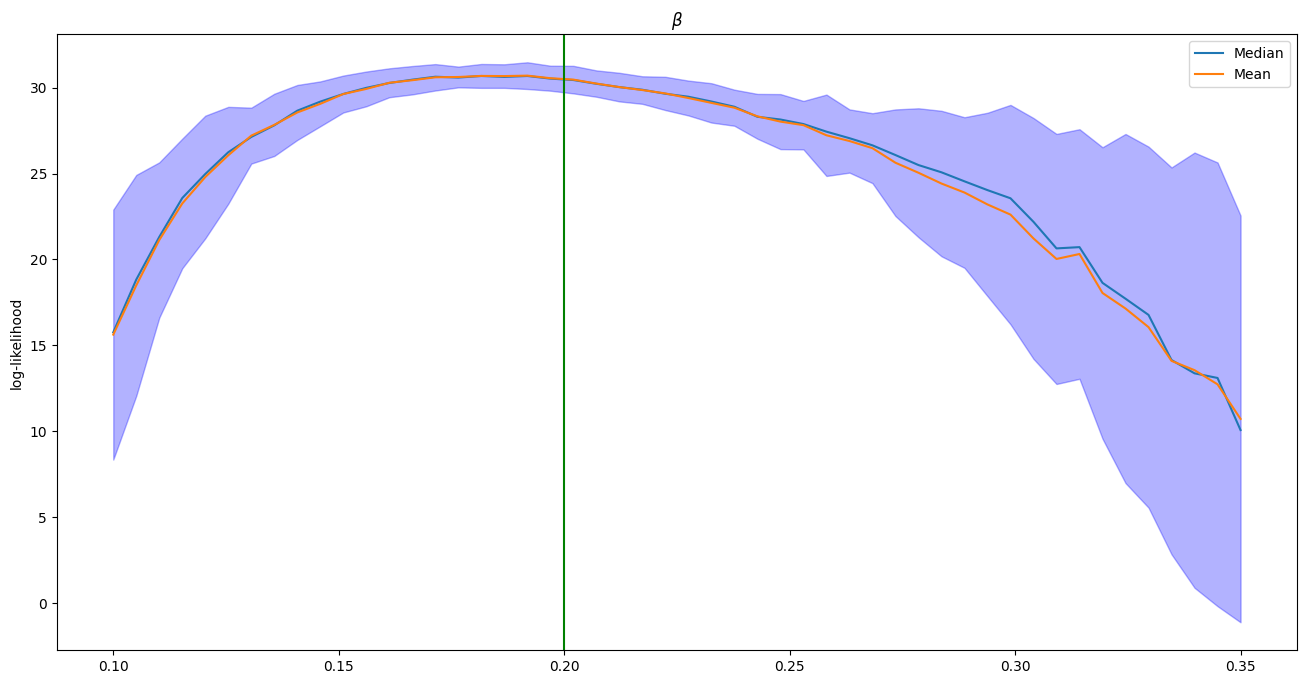

In [27]:
# plot beta
plt.subplots(1,1, figsize=(16,8))

lower_bounds = np.zeros(n_grid)
upper_bounds = np.zeros(n_grid)
medians = np.zeros(n_grid)
means = np.zeros(n_grid)

for i in range(n_grid):
    medians[i] = np.median(logLts_100[keys_beta[i]])
    means[i] = np.mean(logLts_100[keys_beta[i]])
    lower_bounds[i],upper_bounds[i] = stats.norm.interval(confidence=0.95, loc=means[i], scale=np.std(logLts_100[keys_beta[i]]))

sns.lineplot(x = cand_beta,y = medians, label = "Median")
sns.lineplot(x = cand_beta,y = means, label = "Mean")
plt.fill_between(x = cand_beta, y2 = upper_bounds, y1 = lower_bounds, alpha=0.3, color = "blue")
plt.axvline(0.2, 0,max(upper_bounds), color = "green")

plt.title(rf"$\beta$")
plt.legend()
plt.ylabel("log-likelihood")
plt.savefig("Figure_5.5_beta.png")
plt.show()



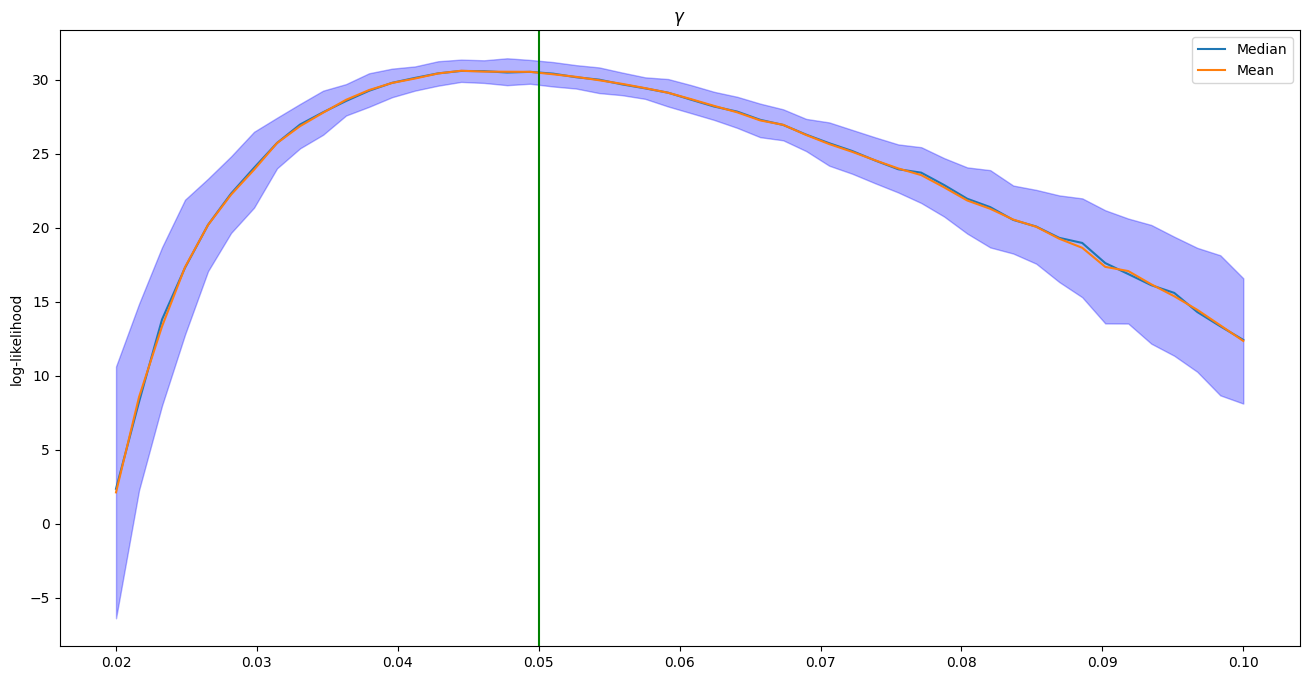

In [29]:
# plot gamma
plt.subplots(1,1, figsize=(16,8))

lower_bounds = np.zeros(n_grid)
upper_bounds = np.zeros(n_grid)
medians = np.zeros(n_grid)
means = np.zeros(n_grid)

for i in range(n_grid):
    medians[i] = np.median(logLts_100[keys_gamma[i]])
    means[i] = np.mean(logLts_100[keys_gamma[i]])
    lower_bounds[i],upper_bounds[i] = stats.norm.interval(confidence=0.95, loc=means[i], scale=np.std(logLts_100[keys_gamma[i]]))

sns.lineplot(x = cand_gamma,y = medians, label = "Median")
sns.lineplot(x = cand_gamma,y = means, label = "Mean")
plt.fill_between(x = cand_gamma, y2 = upper_bounds, y1 = lower_bounds, alpha=0.3, color = "blue")
plt.axvline(0.05, 0,max(upper_bounds), color = "green")

plt.title(rf"$\gamma$")
plt.legend()
plt.ylabel("log-likelihood")
plt.savefig("Figure_5.5_gamma.png")
plt.show()


### 5.6 Samples

The actual sampling procedure combines the SMC method from particles with pyPESTO, where we run the outer scheme as parallel tempered chain. While the chains in the thesis were reported to be stable, the majority of the chains for this code do not converge - this might be based on the same issue that arose with the confidence regions for Figure 5.4. Those chains that converge on the other hand, take around 6 secs for one iteration, making sampling size of $\sim10^5$ rather infeasible. From the several chains that were with 10000, around a third converged and are used for the plots.

In [31]:
# modules
import pypesto
from pypesto import sample

import tempfile

In [32]:
"""Figure 5.6"""

# # prepare for pyPESTO framework
# def PMMH(params):

#     beta = params[0]
#     gamma_inv = 1/params[1]

#     # algorithm
#     fk_model = ssm.Bootstrap(ssm=SIR(beta = beta, gamma_inv = gamma_inv), data=y_syn)
#     alg = particles.SMC(fk=fk_model, N=10, store_history=True)
#     alg.run()

#     return -alg.logLt 

# # define lower and upper bounds
# lb = np.zeros((2, 1))
# ub = np.zeros((2, 1))
# lb[0] = 0.1
# lb[1] = 0.02
# ub[0] = 0.35
# ub[1] = 0.1

# # pyPESTO algorithm
# objective = pypesto.Objective(fun = PMMH)
# problem = pypesto.Problem(objective=objective, lb=lb, ub=ub)

# sampler = sample.AdaptiveParallelTemperingSampler(
#     internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=4
# )

# chain_names  = ["chain_1_10k", "chain_2_10k", "chain_3_10k", "chain_4_10k"]

# for chain in chain_names:  

#     # draw intial values for the chains independently
#     init_values = np.random.uniform([0.001,0.001],[1,0.5])
#     result = sample.sample(
#         problem, 10000, sampler, x0=np.array(init_values), filename=None)
    
#     # save chains
#     fn = tempfile.NamedTemporaryFile(suffix=".hdf5", delete=False)
#     pypesto.store.write_result(
#         result=result,
#         filename=chain,
#         problem=True,
#         optimize=True,
#         profile=True,
#         sample=True,
#     )

'Figure 5.6'

In [44]:
chain_names  = ["chain_1", "chain_2", "chain_3", "chain_4"]     # chains from a classic run, only chain 2 gives reasonable results
chain_names_10k  = ["chain_1_10k", "chain_2_10k", "chain_3_10k", "chain_4_10k"]     # chains from a last run, only chain 3 and 4 give reasonable results
chain_names_working = ["chain_2", "chain_3_10k", "chain_4_10k"]         # converged chains from both runs

Check convergence and quality of original run for the chains

In [45]:
for chain in chain_names:
    result_loaded = pypesto.store.read_result(chain)
    print(rf"{chain}" +" has burn-in of " + rf"{result_loaded.sample_result["burn_in"]}" + " and effective sample size of " + rf"{result_loaded.sample_result["effective_sample_size"]}")

chain_1 has burn-in of None and effective sample size of None
chain_2 has burn-in of None and effective sample size of None
chain_3 has burn-in of None and effective sample size of None
chain_4 has burn-in of None and effective sample size of None


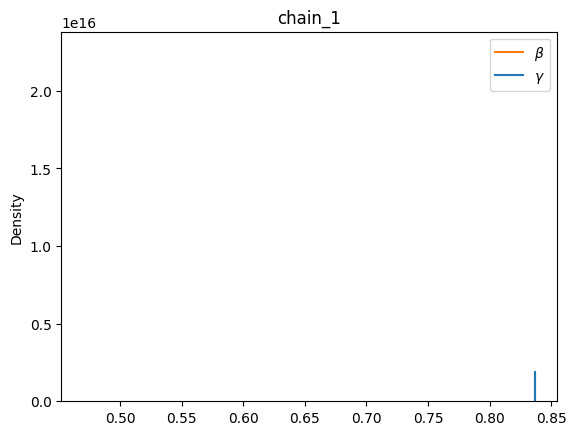

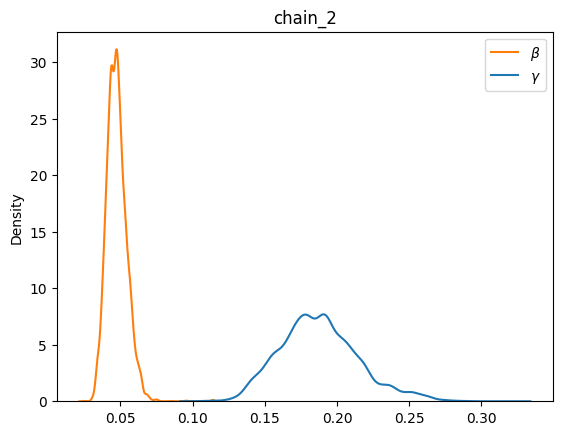

C:\Users\klass\AppData\Local\Temp\ipykernel_14352\1050890270.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(result_loaded.sample_result["trace_x"][0])


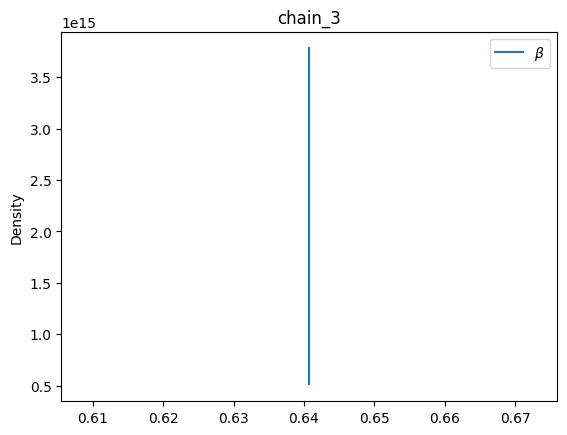

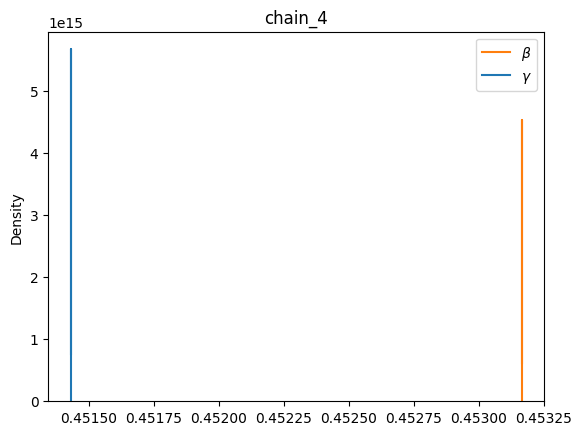

In [46]:
labels = [rf"$\beta$", rf"$\gamma$"]

for chain in chain_names:
    result_loaded = pypesto.store.read_result(chain)
    sns.kdeplot(result_loaded.sample_result["trace_x"][0])
    plt.legend(labels)
    plt.title(rf"{chain}")
    plt.show()

Check results from last run

In [47]:
for chain in chain_names_10k:
    result_loaded = pypesto.store.read_result(chain)
    print(rf"{chain}" +" has burn-in of " + rf"{result_loaded.sample_result["burn_in"]}" + " and effective sample size of " + rf"{result_loaded.sample_result["effective_sample_size"]}")

chain_1_10k has burn-in of None and effective sample size of None
chain_2_10k has burn-in of None and effective sample size of None
chain_3_10k has burn-in of None and effective sample size of None
chain_4_10k has burn-in of None and effective sample size of None


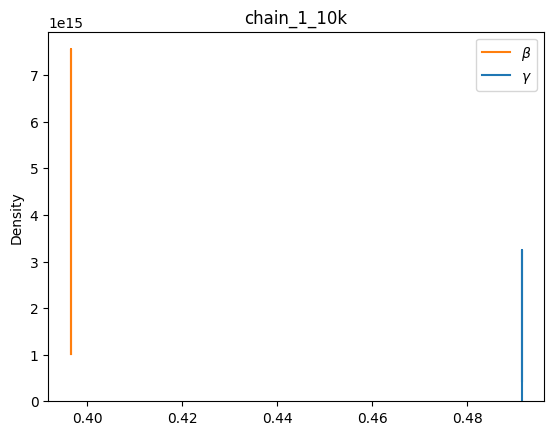

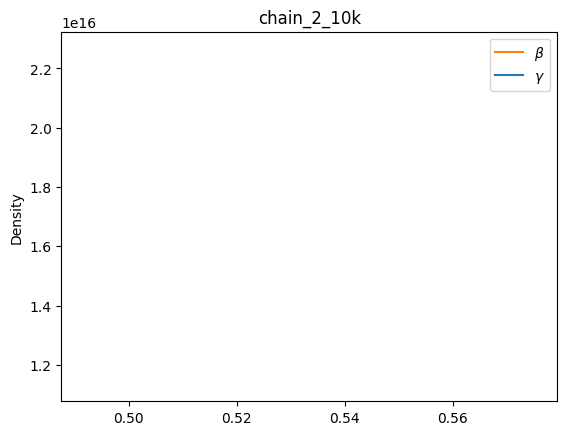

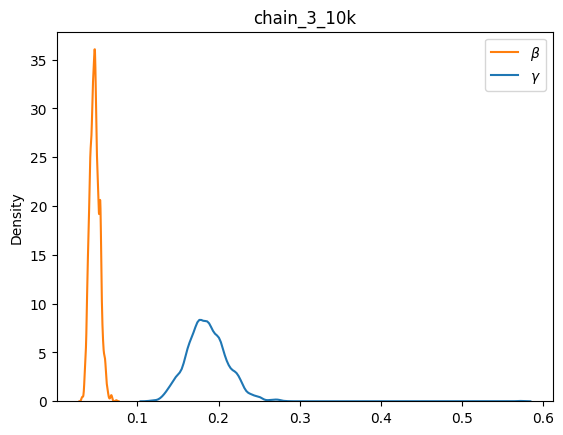

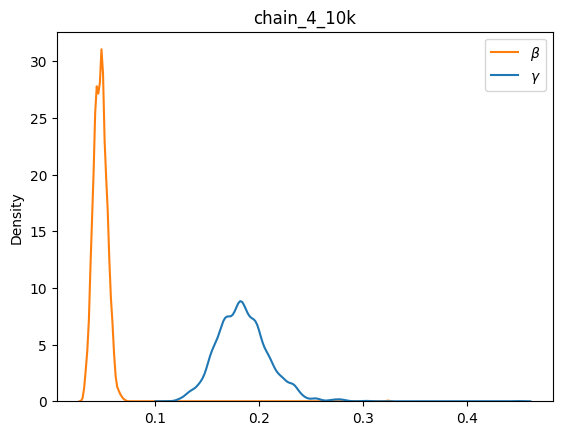

In [48]:
labels = [rf"$\beta$", rf"$\gamma$"]

for chain in chain_names_10k:
    result_loaded = pypesto.store.read_result(chain)
    sns.kdeplot(result_loaded.sample_result["trace_x"][0])
    plt.legend(labels)
    plt.title(rf"{chain}")
    plt.show()

Check converged chains

In [49]:
for chain in chain_names_working:
    result_loaded = pypesto.store.read_result(chain)
    print(rf"{chain}" +" has burn-in of " + rf"{result_loaded.sample_result["burn_in"]}" + " and effective sample size of " + rf"{result_loaded.sample_result["effective_sample_size"]}")

chain_2 has burn-in of None and effective sample size of None
chain_3_10k has burn-in of None and effective sample size of None
chain_4_10k has burn-in of None and effective sample size of None


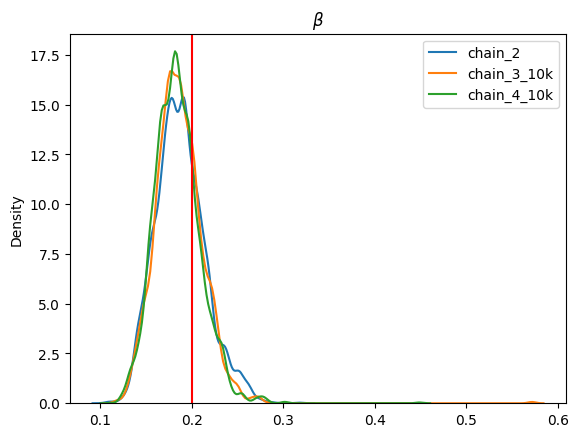

In [50]:
for chain in chain_names_working:
    result_loaded = pypesto.store.read_result(chain)
    sns.kdeplot(result_loaded.sample_result["trace_x"][0][:,0], label = chain)
plt.axvline(0.2, 0,20, color = "red")
plt.title(rf"$\beta$")
plt.legend()
plt.savefig("Figure_5.6_conv_beta.png")
plt.show()

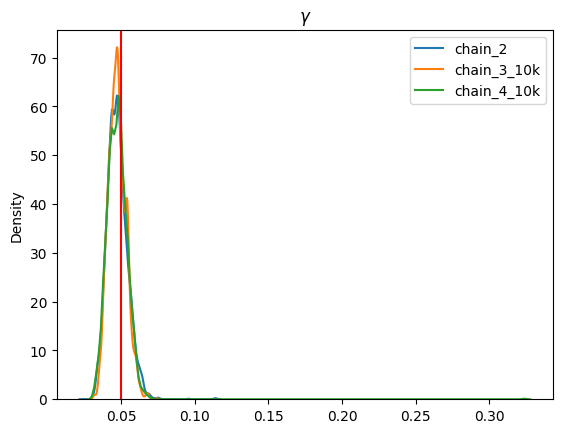

In [51]:
for chain in chain_names_working:
    result_loaded = pypesto.store.read_result(chain)
    sns.kdeplot(result_loaded.sample_result["trace_x"][0][:,1], label = chain)
plt.axvline(0.05, 0,20, color = "red")
plt.title(rf"$\gamma$")
plt.legend()
plt.savefig("Figure_5.6_conv_gamma.png")
plt.show()

Chain ending

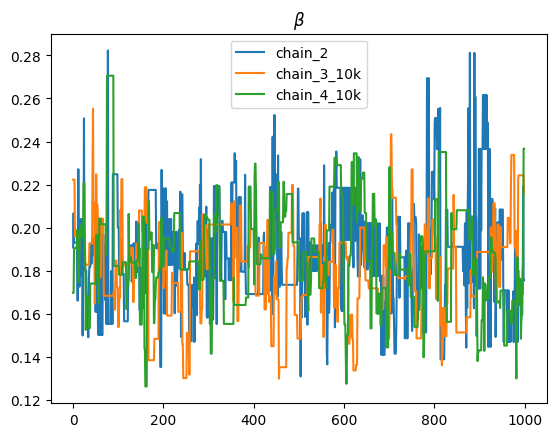

In [58]:
for chain in chain_names_working:
    result_loaded = pypesto.store.read_result(chain)
    sns.lineplot(x = np.arange(0,1000), y = result_loaded.sample_result["trace_x"][0][-1000:,0], label = chain)
plt.title(rf"$\beta$")
plt.legend()
plt.savefig("Figure_5.6_ending_beta.png")
plt.show()

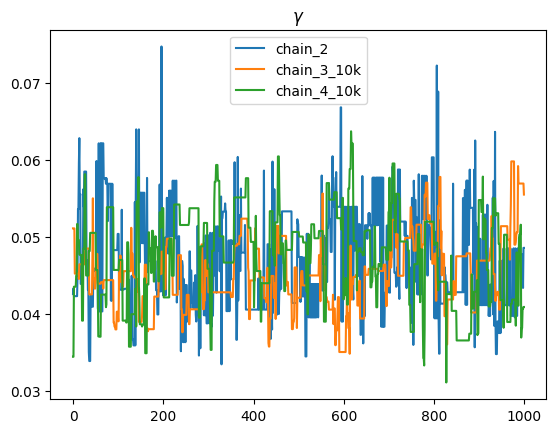

In [59]:
for chain in chain_names_working:
    result_loaded = pypesto.store.read_result(chain)
    sns.lineplot(x = np.arange(0,1000), y = result_loaded.sample_result["trace_x"][0][-1000:,1], label = chain)
plt.title(rf"$\gamma$")
plt.legend()
plt.savefig("Figure_5.6_ending_gamma.png")
plt.show()